In [1]:
import pandas as pd
import numpy as np


df=pd.read_csv('COMBINED_MP_2000-14.xlsx - Sheet1.csv')

In [2]:
df.head()


,Year,Month,Day,Hour,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Wind Speed
0,2000,1,1,0,0,0,0,0,0,0,3,13.986429,964.509827,48.661484,175.597127,2.733917
1,2000,1,1,1,0,0,0,0,0,0,3,13.684157,964.110107,50.296294,162.005468,2.660168
2,2000,1,1,2,0,0,0,0,0,0,3,13.329301,963.844177,51.627187,148.352035,2.655523
3,2000,1,1,3,0,0,0,0,0,0,3,13.000682,963.355286,52.655196,134.784919,2.693983
4,2000,1,1,4,0,0,0,0,0,0,3,12.782371,963.358093,54.141549,121.369895,2.719821


In [5]:
df2 = df.astype(float)
df_new = df.drop(['Year','Month','Day','Hour'],axis=1)

In [7]:
corrMatrix=df_new.corr()
print(corrMatrix)


                         DHI       DNI       GHI  Clearsky DHI  Clearsky DNI  \
DHI                 1.000000  0.710772  0.878277      0.952202      0.925200   
DNI                 0.710772  1.000000  0.933141      0.803306      0.847594   
GHI                 0.878277  0.933141  1.000000      0.916979      0.922735   
Clearsky DHI        0.952202  0.803306  0.916979      1.000000      0.952336   
Clearsky DNI        0.925200  0.847594  0.922735      0.952336      1.000000   
Clearsky GHI        0.941948  0.812544  0.947481      0.959729      0.966939   
Dew Point           0.047399 -0.170536 -0.077991     -0.004525     -0.010994   
Temperature         0.559404  0.461156  0.573514      0.604144      0.517005   
Pressure           -0.138935  0.129484 -0.023573     -0.109901     -0.031210   
Relative Humidity  -0.257673 -0.394039 -0.361187     -0.322891     -0.288742   
Solar Zenith Angle -0.874258 -0.721473 -0.833876     -0.901602     -0.892520   
Wind Speed         -0.008644 -0.130340 -

In [8]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt

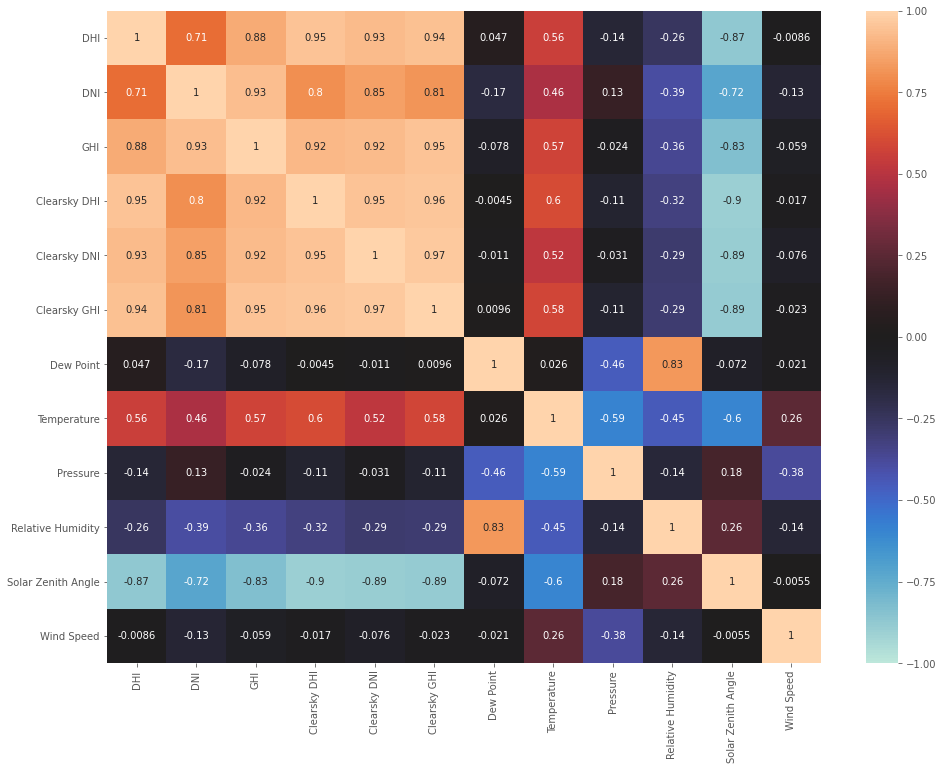

In [9]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot') 

sn.heatmap(df_new.corr(), annot =True, vmin=-1,vmax=1,center =0,fmt ='.2g')
plt.show()

In [10]:
df3 = df2['Wind Speed']


In [11]:
df3.head()


0    2.733917
1    2.660168
2    2.655523
3    2.693983
4    2.719821
Name: Wind Speed, dtype: float64

In [12]:
import scipy.stats as st
bins = 1500

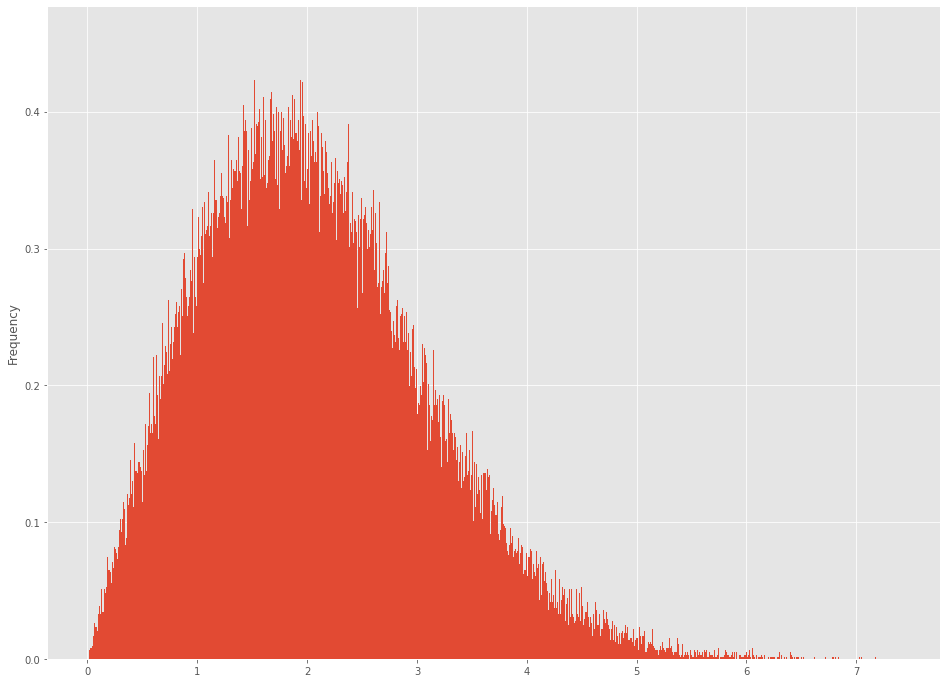

In [13]:
ax = df3.plot(kind='hist',density= True, bins=bins, alpha =1.0)
dataYLim = ax.get_ylim()

In [14]:
import statsmodels.api as sm
import warnings

In [15]:
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    # Distributions to check
    DISTRIBUTIONS = [        
        st.dgamma,st.dweibull, st.alpha,st.weibull_min,st.gamma,st.norm,st.expon,st.rayleigh,st.weibull_max     
    ]
  
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    for distribution in DISTRIBUTIONS:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                params = distribution.fit(data)
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=100):
    """Generate distributions's Probability Distribution Function """
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)
    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)
    return pdf

Text(0, 0.5, 'Frequency')

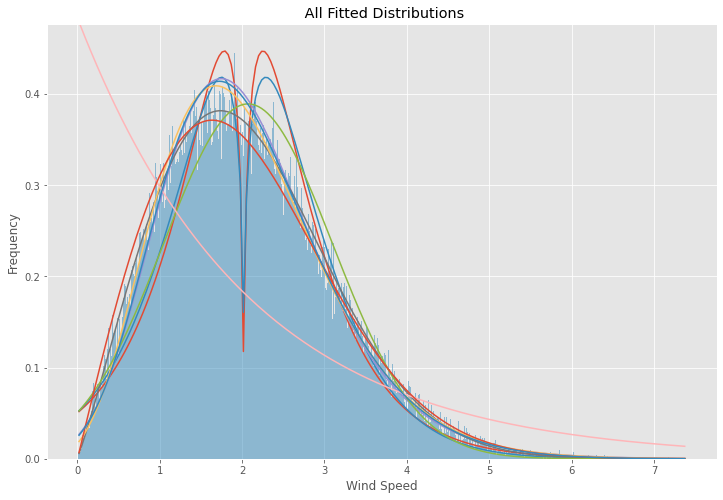

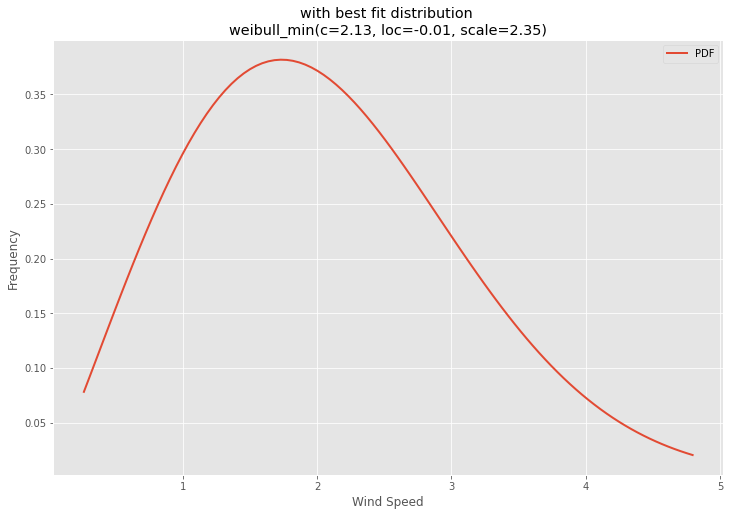

In [19]:
# Load data from statsmodels datasets


# Plot for comparison
plt.figure(figsize=(12,8))
ax = df3.plot(kind='hist', bins=bins,density =True,  alpha=0.5,  color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(df3, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u' All Fitted Distributions')
ax.set_xlabel(u'Wind Speed')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
df3.plot(kind='hist', bins=bins,  alpha=0.5, label='Data', legend=True, ax=ax1)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Wind Speed')
ax.set_ylabel('Frequency')

In [17]:
print(best_fit_name + " : This is approx distribution")


weibull_min : This is approx distribution


Text(3.200000000000003, 0.5, 'freq')

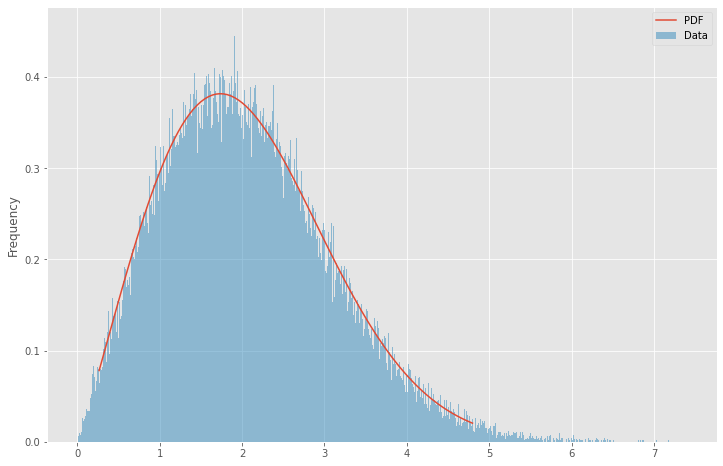

In [18]:
pdf = make_pdf(best_dist, best_fit_params)
plt.figure(figsize=(12,8))
ax1 = pdf.plot(label='PDF', legend=True)
df3.plot(kind='hist', density = True,bins=bins,alpha=0.5, label='Data', legend=True, ax=ax1)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_ylim(dataYLim)
ax.set_xlabel(u'Wind Speed')
ax.set_ylabel('freq')